In [6]:
import math
import numpy as np
import pandas as pd
from collections import Counter
from PyImpetus import PPIMBC
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time


from PyImpetus import PPIMBR
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
#from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split



import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import missingno as msno

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 119 entries, pCR (outcome) to original_ngtdm_Strength
dtypes: float64(111), int64(8)
memory usage: 372.0 KB


,pCR (outcome),PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,RelapseFreeSurvival (outcome),Age,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,144.000000,41.0,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,0.0,1.0,0.0,0.0,3.0,3.0,1.0,1.0,142.000000,39.0,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,135.000000,31.0,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,0.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,12.000000,35.0,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,109.000000,61.0,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,0.0,0.0,1.0,3.0,3.0,1.0,1.0,49.250000,46.1,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,48.500000,53.3,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,47.500000,68.8,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,46.916667,46.0,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


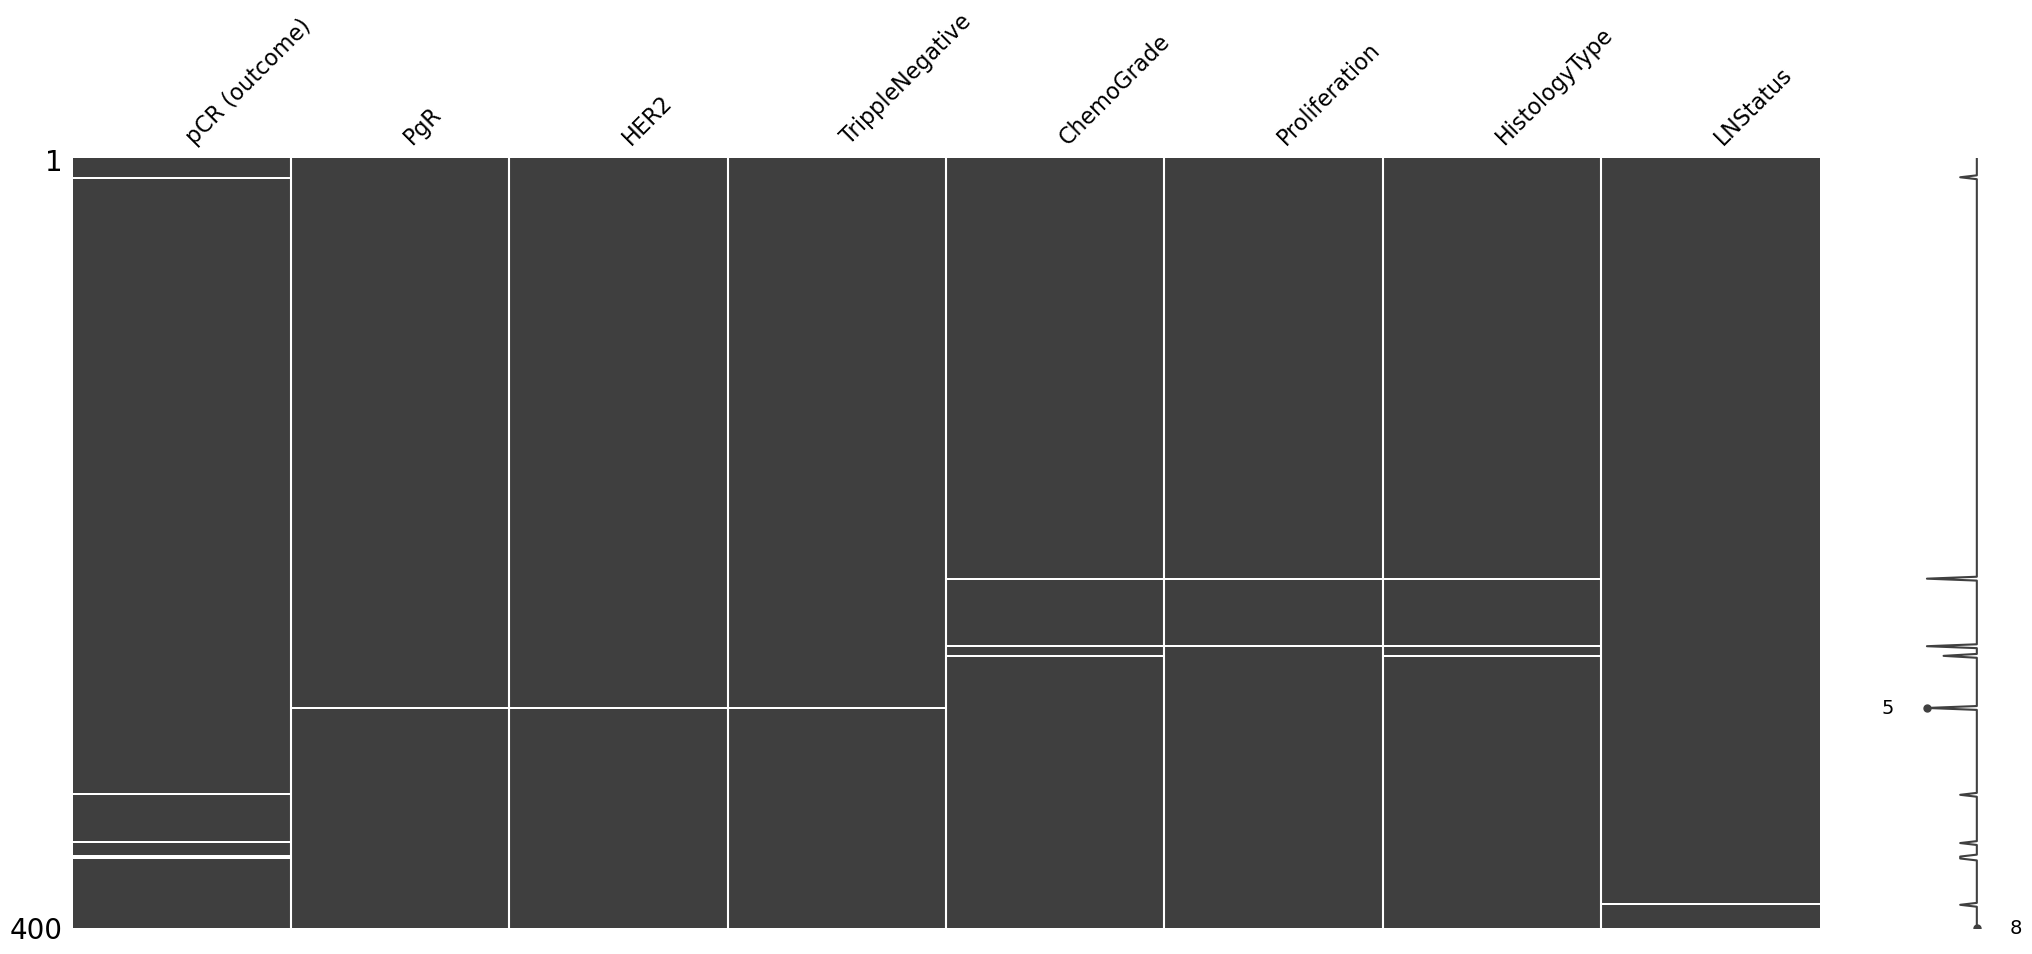

In [8]:
dataFrame = pd.read_excel("trainDataset.xls")
dataFrame.drop("ID", axis=1 ,inplace=True)
dataFrame.head()
dataFrame.info()
dataFrame = dataFrame.replace(999, np.nan)
null_cols = dataFrame.columns[dataFrame.isnull().any()]
msno.matrix(dataFrame[null_cols])

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)

result = imputer.fit_transform(dataFrame)
nonNulldataFrame = pd.DataFrame(result, columns= dataFrame.columns)
nonNulldataFrame = nonNulldataFrame[null_cols].apply(lambda x: round(x))
dataFrame = dataFrame.drop(null_cols, axis=1)
dataFrame = pd.concat([nonNulldataFrame,dataFrame], axis=1)
#checking for missing
nonNulldataFrame.to_csv("test.csv")
dataFrame

In [9]:
## classification with Markov Blanket
data,Y = dataFrame.drop(columns ='pCR (outcome)'), dataFrame['pCR (outcome)'].values
# Lets check out the shape of our data
print("Data shape: ", data.shape, "Target Variable shape: ", Y.shape)
print(dataFrame['pCR (outcome)'].value_counts())

Data shape:  (400, 118) Target Variable shape:  (400,)
0.0    303
1.0     97
Name: pCR (outcome), dtype: int64


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
D:\Anaconda\envs\mle_tf\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parall

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


Markov Blanket:  ['ER', 'PgR', 'HER2', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_ZoneVariance', 'original_gldm_DependenceVariance', 'original_shape_MinorAxisLength', 'original_shape_Maximum2DDiameterRow']
Feature importance:  [9.036879411408394, 8.45300510059318, 6.851042909709157, 6.160839271147856, 5.881552029618836, 3.9122862541863883, 3.5360200652333775, 3.3584241670106385]


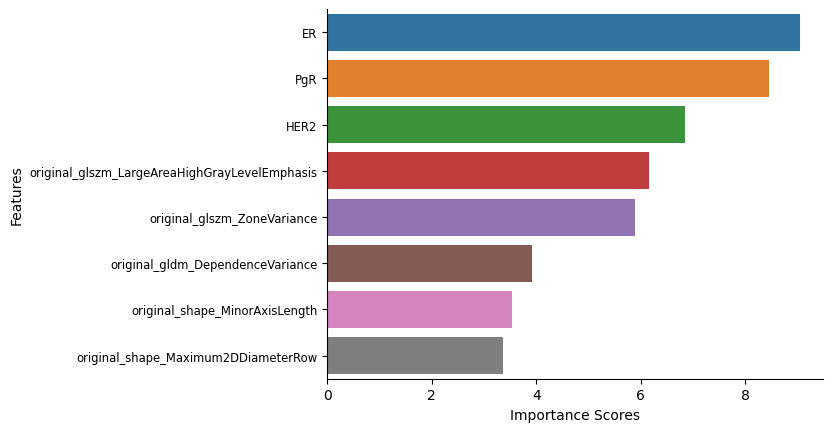

Score:  0.75


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
D:\Anaconda\envs\mle_tf\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parall

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parall

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


Markov Blanket:  ['original_glszm_LargeAreaEmphasis', 'ER', 'PgR', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'HER2', 'original_glrlm_RunPercentage', 'original_gldm_DependenceEntropy', 'original_shape_MeshVolume', 'original_glszm_ZoneVariance', 'LNStatus', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_glrlm_RunVariance', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_gldm_DependenceVariance', 'original_firstorder_10Percentile', 'Proliferation']
Feature importance:  [13.862943611198906, 12.253505698764807, 9.855610425966436, 9.3856067967207, 7.762624659178842, 7.3859358273526405, 6.915006542583937, 6.87406806815058, 6.019879594506852, 5.231707703742009, 4.644238322891096, 4.318419333119523, 4.213961286420002, 4.11144241566066, 4.11144241566066, 3.815485593252747, 3.815485593252747, 3.815485593252747, 3.815485593252747, 3.18749

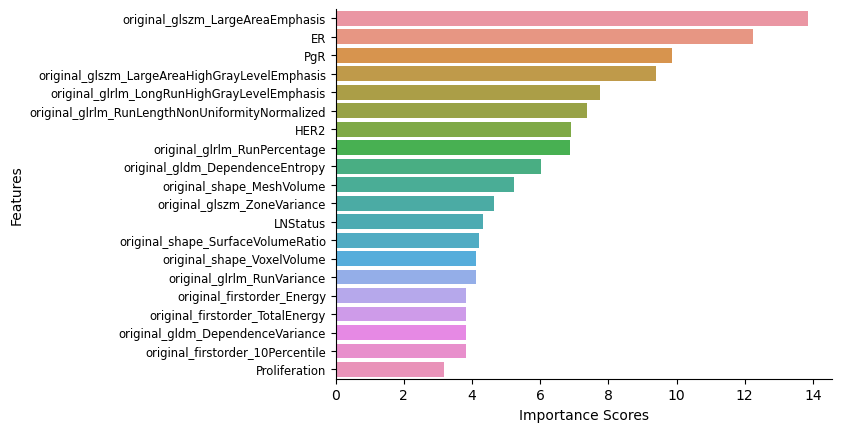

Score:  0.6625


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parall

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.2s finished


Markov Blanket:  ['original_glszm_ZoneVariance', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'ER', 'HER2', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_ngtdm_Coarseness', 'original_gldm_GrayLevelNonUniformity', 'PgR', 'original_glrlm_ShortRunHighGrayLevelEmphasis', 'original_glrlm_RunLengthNonUniformityNormalized', 'original_gldm_DependenceEntropy', 'original_glrlm_RunPercentage', 'original_gldm_DependenceNonUniformity', 'original_glrlm_GrayLevelNonUniformityNormalized', 'LNStatus', 'original_glszm_GrayLevelVariance', 'original_firstorder_Variance', 'Proliferation', 'original_firstorder_InterquartileRange', 'original_gldm_DependenceVariance', 'original_firstorder_RobustMeanAbsoluteDeviation']
Feature importance:  [13.862943611198906, 13.862943611198906, 13.862943611198906, 12.253505698764807, 10.644067786330705, 10.101743495505344, 9.855610425966436, 7.584422187033062, 6.60312400083572, 5.572586836074958, 5.03334075000567, 4.9896156

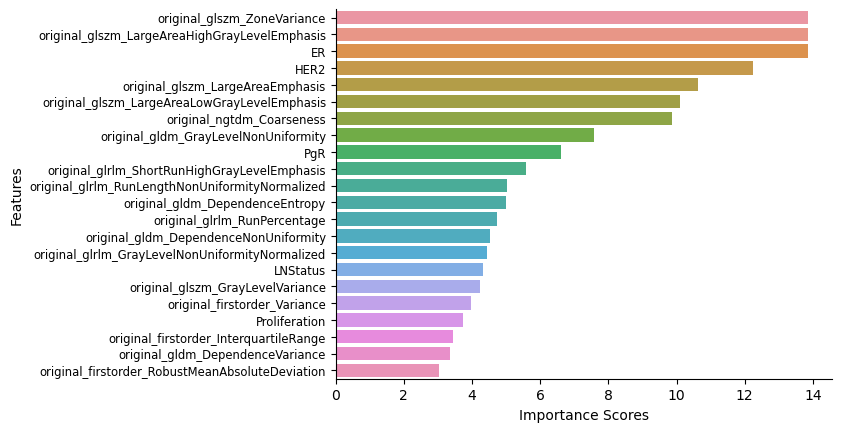

Score:  0.6625


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
D:\Anaconda\envs\mle_tf\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parall

Markov Blanket:  ['original_shape_Maximum3DDiameter', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterSlice', 'original_shape_MinorAxisLength', 'HER2', 'original_shape_LeastAxisLength', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_gldm_GrayLevelNonUniformity', 'original_glrlm_RunVariance', 'original_shape_MajorAxisLength', 'Proliferation', 'LNStatus', 'original_shape_Maximum2DDiameterRow', 'original_glszm_GrayLevelNonUniformity', 'original_shape_SurfaceVolumeRatio']
Feature importance:  [12.253505698764807, 11.560358518204861, 10.918504632032466, 10.101743495505344, 8.530224817933536, 8.329554122471386, 7.584422187033062, 7.4108946567616805, 7.076226660593825, 6.757157481717635, 6.60312400083572, 5.231707703742009, 4.644238322891096, 4.11144241566066, 3.187497697678543]


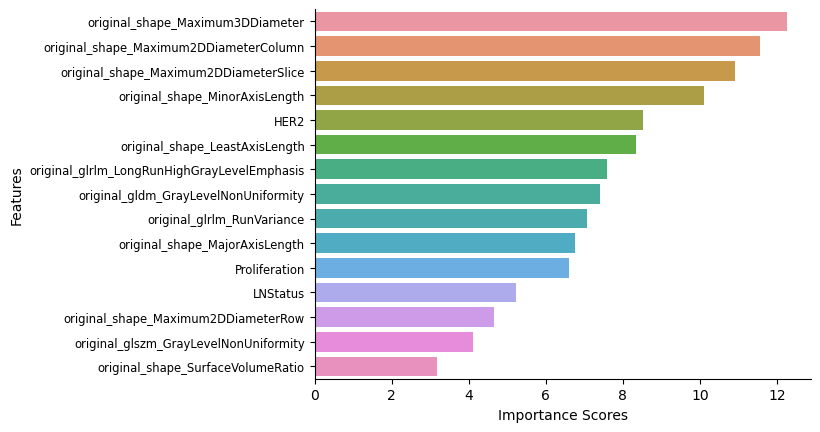

Score:  0.7125


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
D:\Anaconda\envs\mle_tf\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parall

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parall

Markov Blanket:  ['original_glszm_LargeAreaHighGrayLevelEmphasis', 'HER2', 'original_glszm_ZoneVariance', 'original_glszm_LargeAreaEmphasis', 'Proliferation', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_ngtdm_Busyness', 'ER', 'original_firstorder_Variance', 'Age', 'LNStatus', 'ChemoGrade', 'original_gldm_DependenceEntropy', 'PgR', 'original_firstorder_10Percentile', 'original_glrlm_LowGrayLevelRunEmphasis', 'original_gldm_DependenceNonUniformity', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_firstorder_Entropy']
Feature importance:  [13.862943611198906, 13.862943611198906, 12.253505698764807, 8.329554122471386, 7.394805439174169, 6.160839271147856, 5.483634127146055, 5.143779031735481, 4.794662493338073, 4.424910053209942, 4.30852383478902, 4.2936383650409295, 3.720557275404062, 3.6948838137635143, 3.625609842895465, 3.1323244394195964, 3.023029421702323, 3.023029421702323, 3.019123110696216]


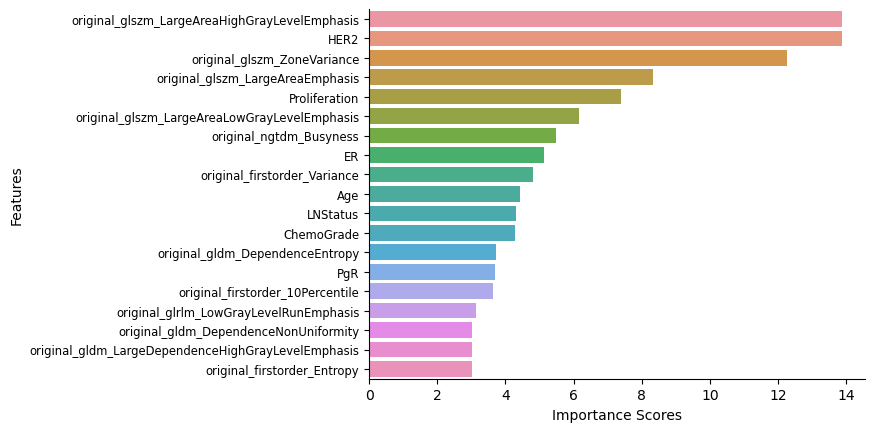

Score:  0.5875


Average Accuracy:  0.675


Total Time Required (in seconds):  139.60938334465027


In [54]:
start = time.time()
# Use KFold for understanding the performance of PyImpetus
kfold = KFold(n_splits=5, random_state=27, shuffle=True)
# This will hold all the accuracy scores
scores = list()
# Perform CV
for train, test in kfold.split(data):
    # Split data into train and test based on folds
    x_train, x_test = data.iloc[train], data.iloc[test]
    y_train, y_test = Y[train], Y[test]

    # Create a PyImpetus classification object and initialize with required parameters
    # NOTE: To achieve fast selection, set cv=0 for disabling the use of any internal cross-validation
    model = PPIMBC(LogisticRegression(random_state=27, max_iter=1000, class_weight="balanced"), cv=0, num_simul=20, simul_type=0, simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=2, p_val_thresh=0.05)
    # Fit this above object on the train part and transform the train dataset into selected feature subset
    # NOTE: x_train has to be a dataframe and y_train has to be a numpy array
    x_train = model.fit_transform(x_train, y_train)
    # Transform the test set as well
    # NOTE: x_test has to be a dataframe
    x_test = model.transform(x_test)
    # Check out the features selected
    print("Markov Blanket: ", model.MB)
    # Check out the scores of each feature. The scores are in order of the selected feature list
    # NOTE: You can use these scores ina feature selection ensemble
    print("Feature importance: ", model.feat_imp_scores)
    # Plot the feature importance scores
    model.feature_importance()
    # Convert the data into numpy arrays
    x_train, x_test = x_train.values, x_test.values
    
    model = DecisionTreeClassifier(random_state=27)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print("Score: ", score)
# Compute average score
print("\n\nAverage Accuracy: ", sum(scores)/len(scores))
# Finally, check out the total time taken
end = time.time()
print("\n\nTotal Time Required (in seconds): ", end-start)

Data shape:  (400, 118) Target Variable shape:  (400,)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 co

Markov Blanket:  ['original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn', 'original_glcm_Idn', 'original_glcm_JointEntropy', 'original_firstorder_Range', 'original_glrlm_LongRunHighGrayLevelEmphasis', 'original_glrlm_ShortRunLowGrayLevelEmphasis', 'Proliferation', 'original_shape_VoxelVolume', 'original_firstorder_Mean', 'original_firstorder_Variance', 'original_firstorder_90Percentile', 'original_glcm_InverseVariance', 'TumourStage', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_firstorder_InterquartileRange', 'original_firstorder_10Percentile', 'original_firstorder_Kurtosis', 'original_shape_MajorAxisLength', 'original_glcm_DifferenceEntropy', 'original_shape_SurfaceArea', 'original_glcm_Autocorrelation', 'original_shape_MeshVolume', 'original_firstorder_Skewness']
Feature importance:  [5.82230641188729, 5.82230641188729, 5.82230641188729, 5.82230641188729, 5.82230641188729, 5.82230641188729, 4.55761654

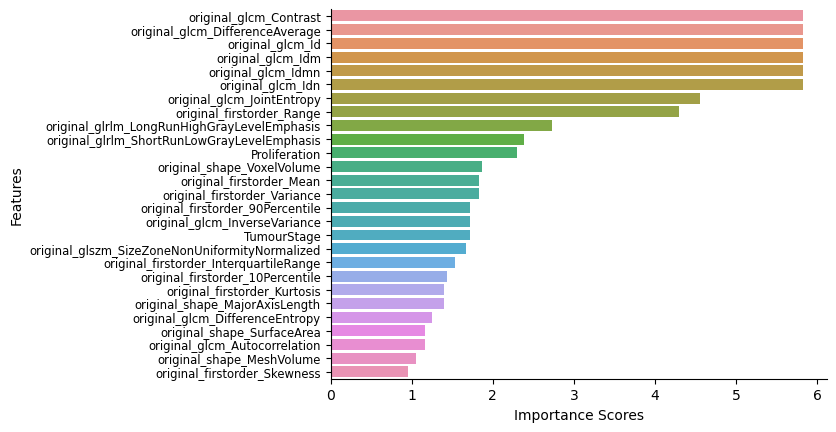

Score:  1236.7270833333334
Time Required (in seconds):  7.232554197311401


In [10]:
data1,Y1 = dataFrame.drop(columns ='RelapseFreeSurvival (outcome)'), dataFrame['RelapseFreeSurvival (outcome)'].values
print("Data shape: ", data1.shape, "Target Variable shape: ", Y1.shape)
# Use Train-test split for understanding the performance of PyImpetus
x_train, x_test, y_train, y_test = train_test_split(data1, Y1, test_size=0.2, random_state=27, shuffle=True)
# We want to time our algorithm
start = time.time()

# Create a PyImpetus classification object and initialize with required parameters
model = PPIMBR(DecisionTreeRegressor(random_state=27), cv=0, p_val_thresh=0.4, num_simul=10, simul_size=0.2, sig_test_type="non-parametric", random_state=27, verbose=2)
# Fit this above object on the train part and transform the train dataset into selected feature subset
# NOTE: x_train has to be a dataframe and y_train has to be a numpy array
x_train = model.fit_transform(x_train, y_train)
# Transform the test set as well
# NOTE: x_test has to be a dataframe
x_test = model.transform(x_test)
# Check out the number of features selected
print("Markov Blanket: ", model.MB)
print("Feature importance: ", model.feat_imp_scores)
print("Number of features selected: ", len(model.MB))
model.feature_importance()
# Convert the data into numpy arrays
x_train, x_test = x_train.values, x_test.values

model = DecisionTreeRegressor(random_state=27)
model.fit(x_train, y_train)
preds = model.predict(x_test)
score = mean_squared_error(y_test, preds)
print("Score: ", score)
end = time.time()
print("Time Required (in seconds): ", end-start)
